In [1]:
import numpy as np
import pandas as pd

In [5]:
iris = pd.read_csv('Data/iris.csv').drop('Id', axis=1)
iris.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [10]:
# train lda

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = iris.iloc[:, :-1].values

y = iris.iloc[:, -1].values

priors = [0.2, 0.5, 0.3]

lda = LinearDiscriminantAnalysis(priors=priors)

lda.fit(X, y)

class_counts = np.bincount(np.unique(y, return_inverse=True)[1])
class_proportions = class_counts / len(y)
class_level_info = pd.DataFrame({
    "Frequency": class_counts,
    "Proportion": class_proportions,
    "Prior": lda.priors_
})

print("Class Level Information:")
print(class_level_info)

Class Level Information:
   Frequency  Proportion  Prior
0         50    0.333333    0.2
1         50    0.333333    0.5
2         50    0.333333    0.3


In [11]:
# Define a function to calculate the pooled covariance matrix
def pooled_cov(X, y):
    classes = np.unique(y)
    n_features = X.shape[1]
    pooled_cov_matrix = np.zeros((n_features, n_features))
    total_samples = 0

    for c in classes:
        X_c = X[y == c]
        cov_c = np.cov(X_c, rowvar=False)  # Covariance matrix for each class
        n_c = X_c.shape[0]
        pooled_cov_matrix += (n_c - 1) * cov_c
        total_samples += n_c

    pooled_cov_matrix /= (total_samples - len(classes))  # Pooled covariance matrix
    return pooled_cov_matrix

pooled_cov_matrix = pooled_cov(X, y)

# Calculate determinant
det_value = np.linalg.det(pooled_cov_matrix)
print("Determinant of pooled covariance matrix:", det_value)

Determinant of pooled covariance matrix: 4.726236653873847e-05


In [14]:
inv_cov = np.linalg.inv(pooled_cov_matrix)  # Inverse of pooled covariance matrix

# Compute Mahalanobis distances and adjusted Mahalanobis distances
maha = np.zeros((3, 3))
mahabis = np.zeros((3, 3))

means = lda.means_

for i in range(3):  # Loop over classes
    for j in range(3):  # Loop over classes
        mu_diff = means[i, :] - means[j, :]  # Mean difference
        maha[i, j] = mu_diff.T @ inv_cov @ mu_diff  # Mahalanobis distance
        mahabis[i, j] = maha[i, j] - 2 * np.log(priors[j])  # Adjusted Mahalanobis distance

# Display results
print("Mahalanobis Distance Matrix:")
print(maha)

print("Adjusted Mahalanobis Distance Matrix:")
print(mahabis)

Mahalanobis Distance Matrix:
[[  0.          89.94296102 179.88082917]
 [ 89.94296102   0.          17.26301734]
 [179.88082917  17.26301734   0.        ]]
Adjusted Mahalanobis Distance Matrix:
[[  3.21887582  91.32925538 182.28877478]
 [ 93.16183685   1.38629436  19.67096295]
 [183.09970499  18.6493117    2.40794561]]


In [20]:
from sklearn.metrics import confusion_matrix

# Make predictions using the LDA model
zpred = lda.predict(X)  # Predicted class labels

# Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y, zpred)
print(conf_matrix)


Confusion Matrix:
[[50  0  0]
 [ 0 48  2]
 [ 0  1 49]]


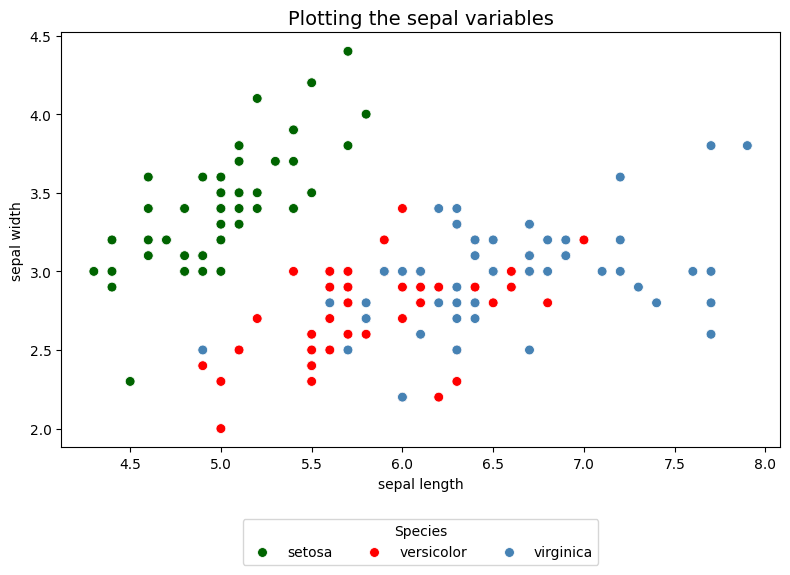

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
data = pd.DataFrame(iris.data, columns=['sepal length', 'sepal width', 'petal length', 'petal width'])
data['species'] = iris.target
data['species'] = data['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})


custom_palette = {
    'setosa': 'darkgreen',
    'versicolor': 'red',
    'virginica': 'steelblue'
}

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data,
    x='sepal length',
    y='sepal width',
    hue='species',
    palette=custom_palette,
    s=50
)

# Add title and adjust legend position
plt.title('Plotting the sepal variables', fontsize=14)
plt.legend(title='Species', loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()

# Show the plot
plt.show()

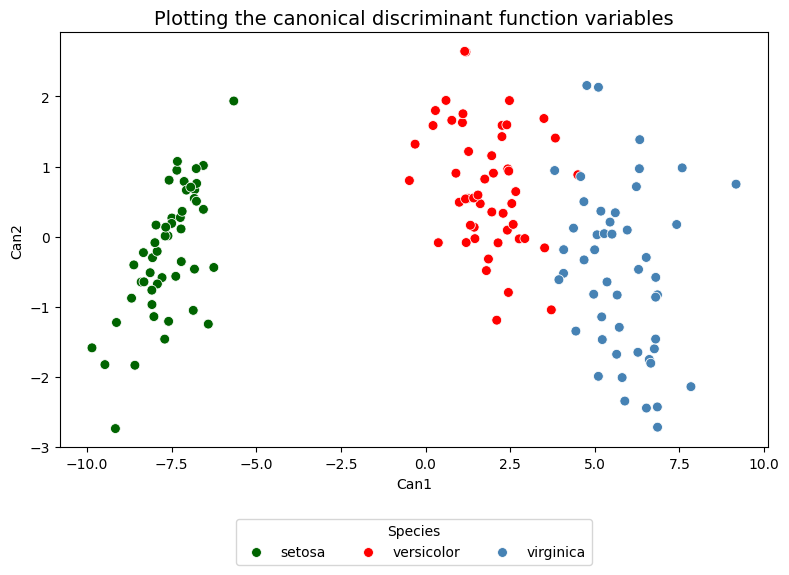

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load the Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
data = pd.DataFrame(iris.data, columns=['sepal length', 'sepal width', 'petal length', 'petal width'])
data['species'] = iris.target
data['species'] = data['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Fit LDA
lda = LinearDiscriminantAnalysis(n_components=2)
lda_fit = lda.fit(data.iloc[:, :-1], data['species'])
lda_transformed = lda.transform(data.iloc[:, :-1])

# Add LD1 and LD2 to the dataset
data['LD1'] = -1 * lda_transformed[:, 0]  # Negating LD1 for comparison with R plot
data['LD2'] = lda_transformed[:, 1]

# Custom colors for species
custom_palette = {
    'setosa': 'darkgreen',
    'versicolor': 'red',
    'virginica': 'steelblue'
}

# Create the scatter plot for LD1 and LD2
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data,
    x='LD1',
    y='LD2',
    hue='species',
    palette=custom_palette,
    s=50
)

# Add title, labels, and legend
plt.title('Plotting the canonical discriminant function variables', fontsize=14)
plt.xlabel('Can1')
plt.ylabel('Can2')
plt.legend(title='Species', loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()

# Show the plot
plt.show()


In [56]:
n1, n2, p = 106, 81, 2

mu1 = np.array([380, 120])
mu2 = np.array([400, 90])

mu = mu1 - mu2

cov = [[25, 40], [40, 100]]

# test if the means are significantly different using the Mahalanobis distance

D2 = mu @ np.linalg.inv(cov) @ mu

test_statistic = (n1 + n2 - p - 1) / (p * (n1 + n2 - 2)) * (n1 * n2 / (n1 + n2)) * D2

print("Mahalanobis distance:", D2)
print("Test statistic:", test_statistic)

from scipy.stats import f

alpha = 0.001

critical_value = f.ppf(1 - alpha, p, n1 + n2 - p - 1)

print("Critical value:", critical_value)

if test_statistic > critical_value:
    print("Reject the null hypothesis that the means are equal.")


# simluate data and learn lda

import numpy as np

np.random.seed(0)

n1, n2, p = 106, 81, 2



n = 1000
X1 = np.random.multivariate_normal(mu1, cov, n)
X2 = np.random.multivariate_normal(mu2, cov, n)

X = np.vstack((X1, X2))

y = np.hstack((np.repeat(1, n), np.repeat(2, n)))

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

lda.fit(X, y)

print("Intercept:", lda.intercept_)
print("Coefficients:", lda.coef_)

Mahalanobis distance: 122.77777777777779
Test statistic: 2803.400491400492
Critical value: 7.173701526026097
Reject the null hypothesis that the means are equal.
Intercept: [-1255.00794761]
Coefficients: [[ 3.69609992 -1.77588724]]


In [63]:
lda.predict([[390, 100]])

array([2])